In [1]:
import numpy as np
from scipy import constants,signal
from matplotlib import pylab as plt
from scipy import signal

%matplotlib inline

## Simple SFCW model

Below is a simple model that ignores the temporal component of a propagating wave, $e^{j 2\pi ft}$, and only considers the spatial frequency. This defines the "impulse" response of the scene, that when convolved with the radar waveforms results received radar data.

\begin{align}
x_{rx}[n] = \sum_{p=1}^{P} a_{p} e^{-j \frac{4 \pi f_n}{c}r_p}
\end{align}

where,
- $f_n = f_0 + n \Delta f$ [Hz] and $ 0 < n < N-1$ 
- $a_p$ is the amplitude of the replected signal for the $p^{th}$ target, where $$a_p =\sqrt{\frac{G^2\sigma\lambda^2} {(4 \pi)^3 r_p^4} }$$
- $G$ is the antenna gain, $\sigma$ is the radar cross section, and $\lambda$ is the wavelength of the propagating electromagnetic rave

In [28]:
def stepped_frequency_cw_radar(f_start=1e9, f_stop=3e9, N=128, targets=[{"range":0.3,"rcs":1}],v=3e8,antenna_gain=4):
    x = np.zeros(N)
    f = np.linspace(f_start,f_stop,N)
    wl = 2*np.pi*f
    k = wl/v
    ao = np.sqrt(antenna_gain**2 * k**2)
    for target in targets:
        rcs = target["rcs"]
        r =  target["range"]
        a = ao*np.sqrt(rcs)/(1+r)**2  # use 1+R to prevent singularly at 0 ,
        x  = x+ a*np.exp(-1j*k*(2*r))
    return f,x



## Signal processing model
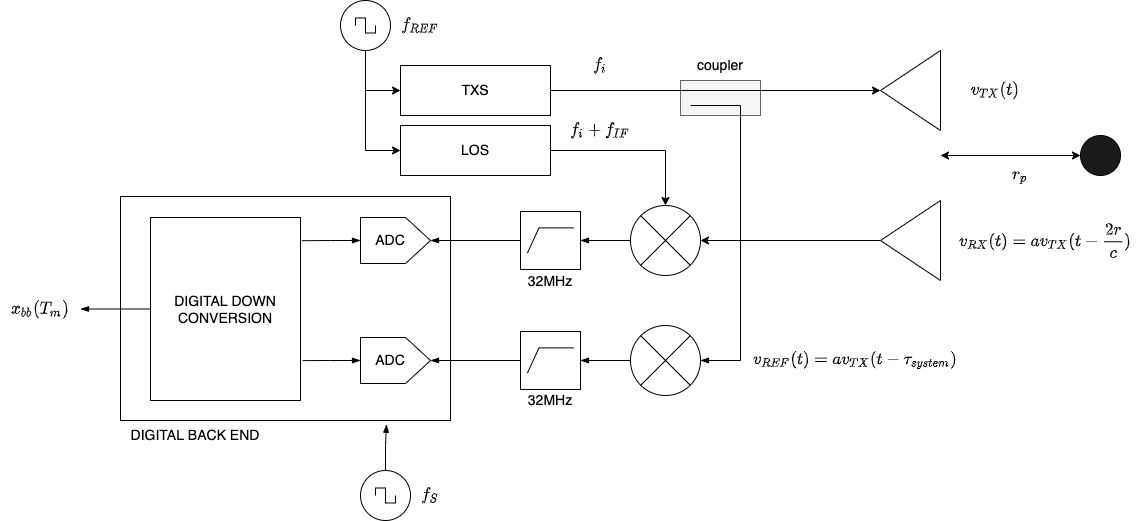

In [3]:
def design_filter(f_cuttoff=10e6,f_transition = 10e6, number_of_taps=64, f_sample=100e6):
    b = signal.remez(number_of_taps, [0, f_cuttoff,f_cuttoff+f_transition, 0.5*f_sample], [1, 0], Hz=f_sample)
    return b,[1]

def sample_filter(x,Ts,dt=100e-9):
    N = len(x)
    L = int(np.round(Ts/dt))
    return 2*np.mean(x[L:N//2])

def continuous_wave(frequency,phase,t):
    y = np.cos(2*np.pi*frequency*t+phase)
    return y



In [4]:
#Radar and model parameters
c=3e8

T_m = 10e-6
f_sample = 100e6
f_if = 5e6
dt = 1/f_sample
K = int(np.round(T_m/dt))
t = np.linspace(0,T_m,K)

f_start=1e9
f_stop = 3e9
N=128
df = (f_stop-f_start)/(N-1)

r_max = c/(2*df)
dr = r_max/(N-1)

amp = 0.5;
phase = np.deg2rad(np.pi/2)

In [5]:
#Generate the carrier free spacial frequency model
targets=[{"range":0.3,"rcs":1},
         {"range":0.6,"rcs":0.2},
         {"range":1.2,"rcs":0.01}]
f,em = stepped_frequency_cw_radar(N=N,targets=targets)

In [6]:
bh,ah = design_filter(12e6,8e6,64,f_sample)
biq,aiq = design_filter(1e6,9e6,64,f_sample)

In [30]:
x_rx = np.zeros(N)
#Phase error to simulate phase noise due to radar system
phase_error_raw = 2*np.pi*np.random.rand(N)*0.1
phase_error_reference = phase_error_raw
for i in range(N):
    #Radar signal (@IF of 10MHz)
    y=np.real(em[i])*continuous_wave(f_if,phase_error_raw[i],t)
    #Refence signal (@IF of 10MHz)
    y_ref = continuous_wave(f_if,phase_error_reference[i],t)

    #Low pass filter of the raw radar and reference channel to remove "harmonic" targets. Will change to band pass filter (better noise performance).
    y_f = signal.filtfilt(bh,ah,y,padlen=150)
    y_ref_f = signal.filtfilt(bh,ah,y_ref,padlen=150)

    #Mix the raw radar return with the reference channel  (mixes to DC).
    y_mix = np.multiply(y_f,y_ref_f)
    #Low pass filter the output to remove mixing products and reduce noise bandwidth
    y_out = signal.filtfilt(biq,[1],y_mix,padlen=150);
    #Sample the output of the low pass filter
    x_rx[i] = sample_filter(y_out,1e-6,dt)


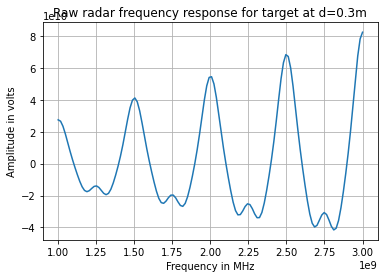

In [8]:
plt.plot(f,x_rx)
plt.xlabel("Frequency in MHz")
plt.ylabel("Amplitude in volts")
plt.title("Raw radar frequency response for target at d=0.3m")
plt.grid()

Text(0.5, 1.0, 'Radar range profile for target at d=0.3m')

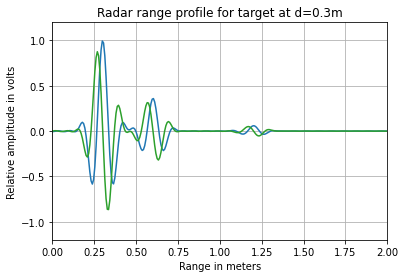

In [9]:
M = 10*N;
l = range(0,M//2)
r = np.linspace(0,r_max,M)
#win = np.hamming(N)
win =signal.windows.dpss(N,2)
x_rx_s = np.fft.fft(np.multiply(x_rx,win),M)
x_rx_s = x_rx_s/np.max(np.abs(x_rx_s))
plt.plot(r[l],np.real(x_rx_s[l]),M);
plt.plot(r[l],np.imag(x_rx_s[l]),M);
plt.grid()
plt.ylim([-1.2,1.2])
plt.xlim([0,2])
plt.xlabel("Range in meters")
plt.ylabel("Relative amplitude in volts")
plt.title("Radar range profile for target at d=0.3m")

Text(0.5, 1.0, 'Radar range profile for target at d=0.3m')

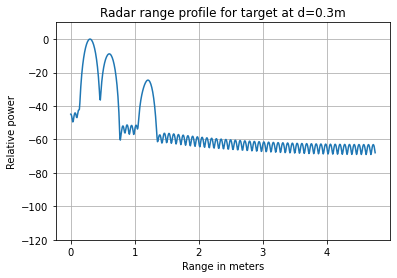

In [10]:
M = 10*N;
l = range(0,M//2)
r = np.linspace(0,r_max,M)

x_rx_s = np.fft.fft(np.multiply(x_rx,win),M)
x_rx_s = x_rx_s/np.max(np.abs(x_rx_s))
plt.plot(r[l],20*np.log10(np.abs(x_rx_s[l])),M);
plt.grid()
plt.ylim([-120,10])

plt.xlabel("Range in meters")
plt.ylabel("Relative power")
plt.title("Radar range profile for target at d=0.3m")